# AE667 : Rotary Aerodynamics Assignment 1
## Flight Performance Estimator
 
## Group 1 : AE 667  

- **Chaitanya Keshri** : 22B2472  
- **Ujjwal Anand** : 25M0049  
- **Bura Charan** : 22B2157  
- **Gauri Maheshwari** : 210010026  


In [1]:
import numpy as np
import math
from typing import Callable, Tuple, Dict


In [2]:

def atmosphere(altitude, delta_ISA=0.0):
    """
    Calculates temperature, pressure, density, and speed of sound 
    at a given altitude with ISA temperature offset.
    
    Inputs:
        altitude   : Altitude [m]
        delta_ISA  : ISA temperature offset [K] (default = 0)
        
    Returns:
        dict with T [K], p [Pa], rho [kg/m³], a [m/s]
    """
    
    # Constants
    T0 = 288.15      # Sea level standard temp [K]
    p0 = 101325.0    # Sea level standard pressure [Pa]
    rho0 = 1.225     # Sea level density [kg/m³]
    a0 = 340.294     # Sea level speed of sound [m/s]
    g = 9.80665      # Gravity [m/s²]
    R = 287.058      # Gas constant for air [J/kg-K]
    L = -0.0065      # Temperature lapse rate [K/m] up to 11 km
    
    # Troposphere only (0–11 km)
    if altitude <= 11000:
        T = T0 + L * altitude + delta_ISA
        p = p0 * (T / (T0 + delta_ISA)) ** (-g / (L * R))
    else:
        # Very simplified: isothermal above 11 km
        T = 216.65 + delta_ISA
        p = p0 * (T / (T0 + delta_ISA)) ** (-g / (L * R)) \
            * math.exp(-g * (altitude - 11000) / (R * T))
    
    rho = p / (R * T)
    a = math.sqrt(1.4 * R * T)
    
    return {"T": T, "p": p, "rho": rho, "a": a}


In [3]:
def airfoil_lift(Cl0, Cl_alpha, alpha0, alpha,alpha_stall=15.0):
    """
    Calculates lift coefficient for a given airfoil at a specified angle of attack in degrees.
    """
    if alpha > alpha_stall:
        return None
    
    alpha_rad = math.radians(alpha)
    alpha0_rad = math.radians(alpha0)
    Cl = Cl0 + Cl_alpha * (alpha_rad - alpha0_rad)
    return Cl

def airfoil_drag(Cd0, Cl, e, AR):
    """
    Calculates drag coefficient using parabolic drag polar.
    """
    Cd = Cd0 + (Cl ** 2) / (math.pi * AR * e)
    return Cd

def airfoil_moment(Cm0, Cm_alpha,alpha0, alpha):
    """
    Calculates pitching moment coefficient for a given airfoil.
    """
    alpha_rad = math.radians(alpha)
    alpha0_rad = math.radians(alpha0)
    Cm = Cm0 + Cm_alpha * (alpha_rad - alpha0_rad)
    return Cm

In [4]:
def chord_r(rotor, r):
    """
    Calculates the chord length at a given radius assuming linear variation from root to tip.
    """
    Rr= rotor["Rr"]
    Rt = rotor["Rt"]
    tip_chord = rotor["chord_tip"]
    root_chord = rotor["chord_root"]
    return root_chord + (tip_chord - root_chord) * (r - Rr) / (Rt - Rr)

In [5]:
def pitch_x(rotor,r):
    """
    Calculates the pitch angle along the blade span assuming linear variation from root to tip in degrees
    """
    Rr= rotor["Rr"]
    Rt = rotor["Rt"]
    theta_root = rotor["theta_root"] 
    theta_tip = rotor["theta_tip"] 
    collective = rotor["collective"]

    return  collective + theta_root + (theta_tip - theta_root) * (r - Rr) / (Rt - Rr)

In [6]:

def solidity(b: int, c_root: float, c_tip: float, R: float, R_root: float = 0.0) -> float:
    """
    Rotor solidity for linearly tapered chord with a root cut-out.

    Formula:
    σ = (Nb * (R - R_root) * (c_root + c_tip) / 2) / (π * R^2)

    Nb:     number of blades [-]
    c_root: chord at R_root [m]
    c_tip:  chord at R [m]
    R:      rotor tip radius [m]
    R_root: root cut-out radius [m]
    """
    if not (0 <= R_root < R):
        raise ValueError("Require 0 <= R_root < R")
    span = R - R_root
    avg_chord = 0.5 * (c_root + c_tip)
    return (b * avg_chord * span) / (math.pi * R**2)

# Function Definitions for BEMT

In [7]:
## inflow calculator 
def Lambda(sigma, a, theta, r, R, V, Omega, R_root=0.0):
    """
    Computes inflow ratio (lambda) at a blade section, accounting for root cut-out.

    Parameters:
    sigma   : float   # Rotor solidity
    a       : float   # Lift curve slope (per rad)
    theta   : float   # Pitch angle (deg)
    r       : float   # Radial location (m)
    R       : float   # Rotor tip radius (m)
    V       : float   # Freestream velocity (m/s)
    Omega   : float   # Rotor angular speed (rad/s)
    R_root  : float   # Root cut-out radius (m), default 0

    Returns:
    lambda_val : float
    """

    # Effective span and normalized radius
    span = R - R_root
    r_bar = (r - R_root) / span  # normalized radius from root cut-out

    theta_r = math.radians(theta)
    lambda_c = V / (Omega * R)

    term1 = (sigma * a / 16) - (lambda_c / 2)
    term2 = (sigma * a / 8) * theta_r * r_bar

    lambda_val = math.sqrt(term1**2 + term2) - term1

    return lambda_val

In [8]:
def induced_velocity(Lambda,Omega,R,V):
    """
    Computes induced velocity at the rotor disk for a given inflow ratio.

    Parameters:
    lambda : float  # Inflow ratio
    Omega  : float  # Rotor angular speed (rad/s)
    R      : float  # Rotor radius (m)

    Returns:
    vi : float
    """
    vi = Lambda * Omega * R - V
    return vi
    
   

### Incorporing Prandatl's Tip Loss model

In [9]:
def LambdaP_hover(sigma, a, F, theta, r, R_tip, R_root=0.0):
    """
    Computes inflow ratio (lambda) for hover with Prandtl's tip loss, accounting for root cut-out.

    Parameters:
    sigma   : float   # Rotor solidity
    a       : float   # Lift curve slope (per rad)
    F       : float   # Tip loss factor
    theta   : float   # Pitch angle (deg)
    r       : float   # Radial location (m)
    R_root  : float   # Root cut-out radius (m), default 0

    Returns:
    lam     : float   # Inflow ratio
    """
    if F == 0:
        return 0
    theta_rad = math.radians(theta)
    term = 1 + (32 * F / (sigma * a)) * theta_rad * r/R_tip
    lam = (sigma * a / (16 * F)) * (math.sqrt(term) - 1)
    return lam

In [10]:
def LambdaP_climb(sigma, a, F, theta, r, R_tip, lambda_c, R_root=0.0):
    """
    Computes inflow ratio (lambda) for climb with Prandtl's tip loss, accounting for root cut-out.

    Parameters:
    sigma     : float   # Rotor solidity
    a         : float   # Lift curve slope (per rad)
    F         : float   # Tip loss factor
    theta     : float   # Pitch angle (deg)
    r         : float   # Radial location (m)
    R         : float   # Rotor tip radius (m)
    lambda_c  : float   # Advance ratio (V / Omega R)
    R_root    : float   # Root cut-out radius (m), default 0

    Returns:
    lam       : float   # Inflow ratio
    """
    if F <= 0:
        return 0
    theta_rad = math.radians(theta)
    term1 = (sigma * a) / (16 * F) - (lambda_c / 2)
    term2 = (sigma * a / (8 * F)) * theta_rad * r/R_tip
    lam = math.sqrt(term1**2 + term2) - term1
    return lam

In [11]:
def LambdaP(flight_condition, sigma, a, F, theta, r, lambda_c, R_tip, R_root=0.0):

    if flight_condition["velocity"][2] == 0:
        return LambdaP_hover(sigma, a, F, theta, r, R_tip, R_root)
    else:
        return LambdaP_climb(sigma, a, F, theta, r, R_tip, lambda_c, R_root)

In [12]:
def tip_loss_factor(b, r, R_tip, lam, R_root=0.0):
    """
    Computes Prandtl's tip loss factor, accounting for root cut-out.

    Parameters:
    b      : int    # Number of blades
    r      : float  # Radial location (m)
    R      : float  # Rotor tip radius (m)
    lam    : float  # Local inflow ratio
    R_root : float  # Root cut-out radius (m), default 0

    Returns:
    F      : float  # Tip loss factor
    """
    if lam == 0:
        return 0.0
    f = (b / 2) * (1 - r/R_tip) / lam
    F = (2 / math.pi) * math.acos(math.exp(-f))
    return F

In [13]:
def compute_phi(V, v, Omega, r, R_root=0.0):
    """
    Computes the inflow angle (phi) at a blade section and returns it in degrees.

    Parameters:
    V      : float  # Freestream velocity (m/s)
    v      : float  # Induced velocity (m/s)
    Omega  : float  # Rotor angular speed (rad/s)
    r      : float  # Radial location (m), should be >= R_root
    R_root : float  # Root cut-out radius (m), default 0

    Returns:
    phi_deg : float  # Inflow angle in degrees
    """
    Ut = Omega * r
    Up = V + v
    phi_rad = math.atan2(Up, Ut)
    phi_deg = math.degrees(phi_rad)
    
    return phi_deg

In [14]:
def solve_lambda_tiploss(flight_condition, sigma, a, b, theta_deg, r,lambda_c, R_tip, R_root=0.0,tol=1e-3, max_iter=5):
    """
    Iteratively solves for lambda and Prandtl's tip loss factor F at a blade station.
    Starts from F=1, updates lambda and F until convergence.
    Returns: (lambda, F)
    """
    F = 1.0
    for _ in range(max_iter):
        lam_new = LambdaP(flight_condition, sigma, a, F, theta_deg, r, lambda_c, R_tip, R_root)
        F_new = tip_loss_factor(b, r, R_tip, lam_new, R_root)
        #print("F_new",F_new)
        if abs(F_new - F) < tol:
            return lam_new, F_new
        F = F_new
    return (lam_new, F_new)  # Return last values if not converged

In [15]:
def density_ratio(h):
    """
    Computes density ratio (rho / rho0) as a function of altitude h (meters).
    Equation: (1 - 0.00198*h / 288.16) ^ 4.2553
    """
    return (1 - (0.00198 * h) / 288.16) ** 4.2553



### Iterative solver 

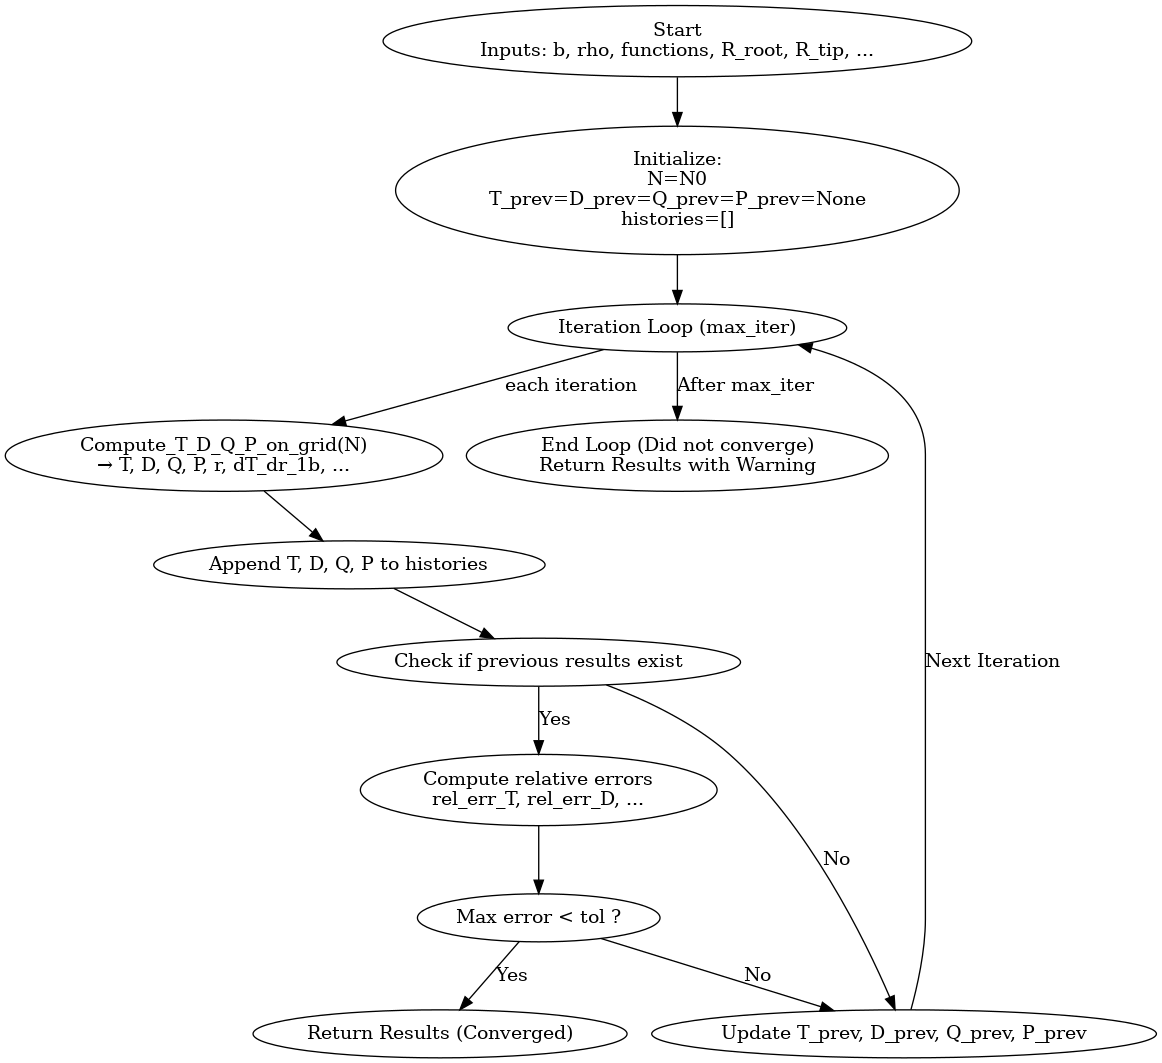

In [16]:
import numpy as np
from typing import Callable, Dict

def iterative_solver(
    b: int,
    rho: float,
    Ut_fn: Callable[[float], float],
    Up_fn: Callable[[float], float],
    c_fn: Callable[[float], float],
    Cl_fn: Callable[[float], float],
    phi_fn: Callable[[float], float],
    Cd_fn: Callable[[float], float],
    R_root: float,
    R_tip: float,
    N0: int = 200,       # fixed high resolution grid
    max_iter: int = 10,
    tol: float = 1e-3    # relative tolerance
) -> Dict:
    
    def compute_T_D_Q_P_on_grid(N: int):
        r = np.linspace(R_root, R_tip, N)
        Ut = np.array([Ut_fn(ri) for ri in r])
        Up = np.array([Up_fn(ri) for ri in r])
        c  = np.array([c_fn(ri)  for ri in r])
        Cl = np.array([Cl_fn(ri) for ri in r], dtype=float)
        phi = np.array([phi_fn(ri) for ri in r])
        Cd  = np.array([Cd_fn(ri) for ri in r])

        V2 = Ut**2 + Up**2
        q = 0.5 * rho * V2
        phi_r = np.radians(phi) 

        dT_dr_1b = q * c * (Cl * np.cos(phi_r) - Cd * np.sin(phi_r))
        dD_dr_1b = q * c * (Cl * np.sin(phi_r) + Cd * np.cos(phi_r))
        dQ_dr_1b = r * q * c * (Cd * np.cos(phi_r) + Cl * np.sin(phi_r))
        dP_dr_1b = (Ut / r) * dQ_dr_1b

        T = b * np.trapezoid(dT_dr_1b, r)
        D = b * np.trapezoid(dD_dr_1b, r)
        Q = b * np.trapezoid(dQ_dr_1b, r)
        P = b * np.trapezoid(dP_dr_1b, r)

        return T, D, Q, P, r, dT_dr_1b, dD_dr_1b, dQ_dr_1b, dP_dr_1b, q

    N = N0
    history_T, history_D, history_Q, history_P = [], [], [], []
    T_prev = D_prev = Q_prev = P_prev = None

    for it in range(max_iter):
        T, D, Q, P, r, dT_dr_1b, dD_dr_1b, dQ_dr_1b, dP_dr_1b, q = compute_T_D_Q_P_on_grid(N)

        history_T.append(T)
        history_D.append(D)
        history_Q.append(Q)
        history_P.append(P)

        if T_prev is not None:
            rel_err_T = abs((T - T_prev) / T_prev)
            rel_err_D = abs((D - D_prev) / D_prev)
            rel_err_Q = abs((Q - Q_prev) / Q_prev)
            rel_err_P = abs((P - P_prev) / P_prev)
            # check relative errors
            if max(rel_err_T, rel_err_Q, rel_err_P, rel_err_D) < tol:
                return {
                    "T": float(T), "D": float(D), "Q": float(Q), "P": float(P),
                    "N": N,
                    "r": r,
                    "dT_dr_per_blade": dT_dr_1b,
                    "dD_dr_per_blade": dD_dr_1b,
                    "dQ_dr_per_blade": dQ_dr_1b,
                    "dP_dr_per_blade": dP_dr_1b,
                    "q": q,
                    "history_T": history_T,
                    "history_D": history_D,
                    "history_Q": history_Q,
                    "history_P": history_P,
                    "stall_status": 0
                }

        T_prev, D_prev, Q_prev, P_prev = T, D, Q, P

    return {
        "T": float(T), "D": float(D), "Q": float(Q), "P": float(P),
        "N": N,
        "r": r,
        "dT_dr_per_blade": dT_dr_1b,
        "dD_dr_per_blade": dD_dr_1b,
        "dQ_dr_per_blade": dQ_dr_1b,
        "dP_dr_per_blade": dP_dr_1b,
        "q": q,
        "history_T": history_T,
        "history_D": history_D,
        "history_Q": history_Q,
        "history_P": history_P,
        "stall_status": 0,
        "warning": "Did not converge"
    }


### Defining the Start Simulation Function

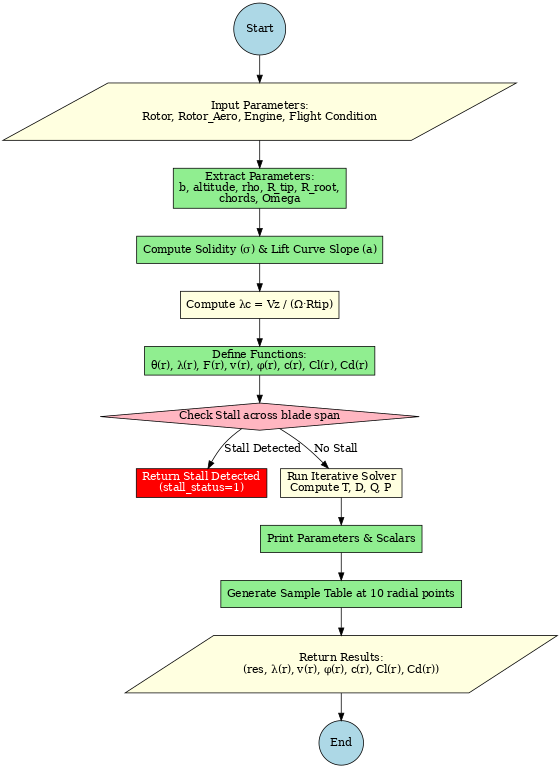

In [17]:
import pandas as pd

def Sim_Start(rotor, rotor_aero, engine, flight_condition):
    
    b = rotor["b"]
    altitude = flight_condition["altitude"]
    rho = atmosphere(altitude, delta_ISA=flight_condition["delta_ISA"])["rho"]
    R_tip  = rotor["Rt"]
    R_root = rotor["Rr"]
    C_tip = rotor["chord_tip"]
    C_root = rotor["chord_root"]
    Omega = engine["omega"]


    sigma = solidity(b, C_root,C_tip, R_tip)
    a = rotor_aero["Cl_alpha"]

    V_val = flight_condition["velocity"][2] # vertical velocity component (w)
    lambda_c =  V_val/ (Omega * R_tip)  # advance ratio

    # Pitch angle as a function of r
    theta_fn = lambda r: pitch_x(rotor, r)

    # Inflow ratio lambda as a function of r, with tip loss factor
    Lambda_tiploss = lambda r: solve_lambda_tiploss(flight_condition, sigma, a, b, theta_fn(r), r, lambda_c, R_tip, R_root)
    lembda_fn = lambda r: Lambda_tiploss(r)[0]
    F_fn = lambda r: Lambda_tiploss(r)[1]
    
    #[print(Lambda_tiploss(r)) for r in np.linspace(R_root, R_tip, 5)] # debug print
    
    # Induced velocity as a function of r
    v_fn = lambda r: induced_velocity(lembda_fn(r), Omega, R_tip, V_val)
 
    # Inflow angle phi as a function of r
    phi_fn = lambda r: compute_phi(V_val, v_fn(r), Omega, r, R_root)

    # Chord as a function of r
    c_fn = lambda r: chord_r(rotor,r)

    

    # Lift coefficient as a function of r
    Cl_fn = lambda r: airfoil_lift(
        Cl0=rotor_aero["Cl0"],
        Cl_alpha=rotor_aero["Cl_alpha"],
        alpha0=rotor_aero["alpha0"],
        alpha = theta_fn(r) - phi_fn(r),
        alpha_stall=rotor_aero["alpha_stall"]

    )

    # Aspect ratio estimate for drag calculation?
    AR = (R_tip - R_root) / ((C_root + C_tip) / 2)

    # Drag coefficient as a function of r
    Cd_fn = lambda r: airfoil_drag(
        Cd0=rotor_aero["Cd0"],
        Cl=Cl_fn(r),
        e=rotor_aero["e"],
        AR=AR
    )


    # Check stall across all radii (not just samples)
    r_all = np.linspace(R_root, R_tip, 200)   # dense discretization
    for r in r_all:
        alpha = theta_fn(r) - phi_fn(r)
        if alpha > rotor_aero["alpha_stall"]:
            print(f"Stall detected at r = {r:.3f} m, alpha = {alpha:.3f} deg")
            return ({"stall_status": 1, "r": r, "alpha": alpha},)
        
        
    # Now run the iterative thrust calculation
    res = iterative_solver(
        b=b, rho=rho,
        Ut_fn=lambda r: Omega * r,
        Up_fn=lambda r: V_val + v_fn(r),
        c_fn=c_fn, Cl_fn=Cl_fn, phi_fn=phi_fn, Cd_fn=Cd_fn,
        R_root=R_root, R_tip=R_tip,
        N0 = 200, max_iter= 100, tol=1e-3
    )

    # Print scalar variables
    print("b =", b)
    print("rho =", rho)
    print("altitude =", flight_condition["altitude"])
    print("R_tip =", R_tip)
    print("R_root =", R_root)
    print("Omega =", Omega)
    print("sigma =", sigma)
    print("a =", a)
    print("V_val =", V_val)
    print("AR =", AR)

    # Tabulate sample values at selected radial positions
    sample_r = np.linspace(R_root, R_tip, 10)
    table = []

    for r in sample_r:
        table.append({
            "r (m)": round(r, 3),
            "theta (deg)": round(theta_fn(r), 3),
            "F (tip loss)": round(F_fn(r), 4),
            "lambda": round(lembda_fn(r), 5),
            "v_induced (m/s)": round(v_fn(r), 4),
            "phi (deg)": round(phi_fn(r), 3),
            "chord (m)": round(c_fn(r), 4),
            "Cl": round(Cl_fn(r), 4),
            "Cd": round(Cd_fn(r), 5)
        })


    df = pd.DataFrame(table)
    print("\nSample values at selected r:")
    print(df.to_string(index=False))

    # # Tabulate arrays from iterative_thrust result (first 5 values for brevity)
    # tab_array = pd.DataFrame({
    #     "r (m)": res["r"],
    #     "dT_dr_per_blade": res["dT_dr_per_blade"],
    #     "dD_dr_per_blade": res["dD_dr_per_blade"],
    #     "dQ_dr_per_blade": res["dQ_dr_per_blade"],
    #     "dP_dr_per_blade": res["dP_dr_per_blade"],
    #     "q": res["q"]
    # })
    # #print("\nElemental values along blade (first 5 rows):")
    # #print(tab_array.head().to_string(index=False))
    # # Print histories and converged values

    print("\nConverged T (Thrust) =", res["T"], "N")
    print("Converged D (Drag)   =", res["D"], "N")
    print("Converged Q (Torque) =", res["Q"], "Nm")
    print("Converged P (Power)  =", res["P"], "W")

    # print("Grid points used  =", res["N"])
    # if "warning" in res:
    #     print("Warning:", res["warning"])
        
        
    return (res,lembda_fn, v_fn, phi_fn, c_fn, Cl_fn, Cd_fn)



# Mission Planner 

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def Mission_Planner(fuel_weight, hover_endurance, climb_endurance, climb_velocity):

    if fuel_weight > fuselage["max_fuel_weight"]:
        print(f"Mission Failed: Fuel weight exceeds max of {fuselage['max_fuel_weight']} kg")
        return

    corrected_engine_power = engine["max_power_avail"] * density_ratio(flight_condition["altitude"])

    # -------------------- INITIAL TOGW --------------------
    TOGW = fuel_weight + fuselage["Empty_Weight"] + payload["weight"]
    print("TAKe offf gross weight",TOGW)
    
    times, weights, fuels, hover_SEs, climb_SEs = [], [], [], [], []
    fuel_rates = []   # store phase_fuel_rate values
    phases = []       # keep track of phase (hover/climb)
    pahse_power_arr = []

    current_fuel = fuel_weight
    current_weight = TOGW
    t = 0

    # -------------------- SIMULATION LOOP --------------------
    for phase, duration in [("hover", hover_endurance), ("climb", climb_endurance)]:
        for i in range(int(duration)):

            thrust_req = current_weight * 9.81

            if phase == "hover":
                flight_condition_now = flight_condition.copy()
                flight_condition_now["velocity"] = [0, 0, 0]
            else:
                flight_condition_now = flight_condition.copy()
                flight_condition_now["velocity"] = [0, 0, climb_velocity]

            found_collective = None
            for col in np.linspace(0, rotor_aero["alpha_stall"]+1, 100):
                rotor["collective"] = col
                res = Sim_Start(rotor=rotor, rotor_aero=rotor_aero,
                                engine=engine, flight_condition=flight_condition_now)
                if res[0]["stall_status"] == 1:
                    continue
                if res[0]["T"] >= thrust_req:
                    found_collective = col
                    break

            if found_collective is None:
                print(f"Mission Failed: Cannot sustain {phase} at t={t} min")
                return

            phase_power = res[0]["P"] / (1 - tail_rotor["power_fraction"]) / (1 - engine["engines_loss"])
            pahse_power_arr.append(phase_power)
            if phase_power > corrected_engine_power:
                print(f"Mission Failed: Insufficient {phase} power {phase_power} > {corrected_engine_power} at t={t} min for {TOGW} kg")
                return

            # Fuel burn this minute
            bsfc = engine["bsfc"]  # kg/kWh
            phase_fuel_rate = (bsfc * (phase_power/1000)) / 60  # kg/min
            current_fuel -= phase_fuel_rate
            current_fuel = max(current_fuel, 0)

            # Update weights
            current_weight = fuselage["Empty_Weight"] + payload["weight"] + current_fuel

            # Store results
            times.append(t)
            weights.append(current_weight)
            fuels.append(current_fuel)
            fuel_rates.append(phase_fuel_rate)
            phases.append(phase)

            # SE storage
            SE = 1/phase_fuel_rate if phase_fuel_rate > 0 else np.inf
            if phase == "hover":
                hover_SEs.append(SE)
                climb_SEs.append(None)
            else:
                hover_SEs.append(None)
                climb_SEs.append(SE)

            # Print status
            print(f"\n--- t = {t} min | Phase: {phase.upper()} ---")
            print(f"Gross Weight: {current_weight:.2f} kg | Fuel Remaining: {current_fuel:.2f} kg")
            print(f"Fuel Rate: {phase_fuel_rate:.4f} kg/min")

            t += 1
            if current_fuel <= 0:
                print(f"Fuel exhausted at t={t} min")
                return 
            

    print("\nMission Feasible ✅")
    print(f"Initial TOGW: {TOGW:.1f} kg")
    print(f"Total Fuel Used: {fuel_weight - current_fuel:.2f} kg")
    print(f"Final TOGW: {current_weight:.2f} kg")   
    print("collective angle",found_collective)
    print(f"Total Mission Time: {t} minutes")
    print("Avialable Power (W)",corrected_engine_power)
    print("Power Required(W)", pahse_power_arr[-1])
    

    # -------------------- PLOTTING --------------------
    # 1. Vehicle Weight vs Time
    plt.figure(figsize=(10, 5))
    plt.plot(times, weights, label="Vehicle Weight (kg)", linewidth=2)
    plt.title("Vehicle Weight vs Time")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Weight (kg)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

    # 2. Fuel Remaining vs Time
    plt.figure(figsize=(10, 5))
    plt.plot(times, fuels, label="Fuel Remaining (kg)", linewidth=2, color="orange")
    plt.title("Fuel Remaining vs Time")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Fuel (kg)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

    # 3. Phase Fuel Rate vs TOGW (kgf instead of kg)
    plt.figure(figsize=(8, 6))
    for phase_name, color in zip(["hover", "climb"], ["green", "red"]):
        x = [f for f, p in zip(fuel_rates, phases) if p == phase_name]
        y = [w * 9.81 for w, p in zip(weights, phases) if p == phase_name]  # convert to kgf
        if x and y:
            plt.plot(x, y, label=phase_name.capitalize(), linewidth=2, color=color)

    plt.title("Phase Fuel Rate vs TOGW")
    plt.xlabel("Fuel Burn Rate (kg/min)")
    plt.ylabel("Gross Weight (kgf)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()



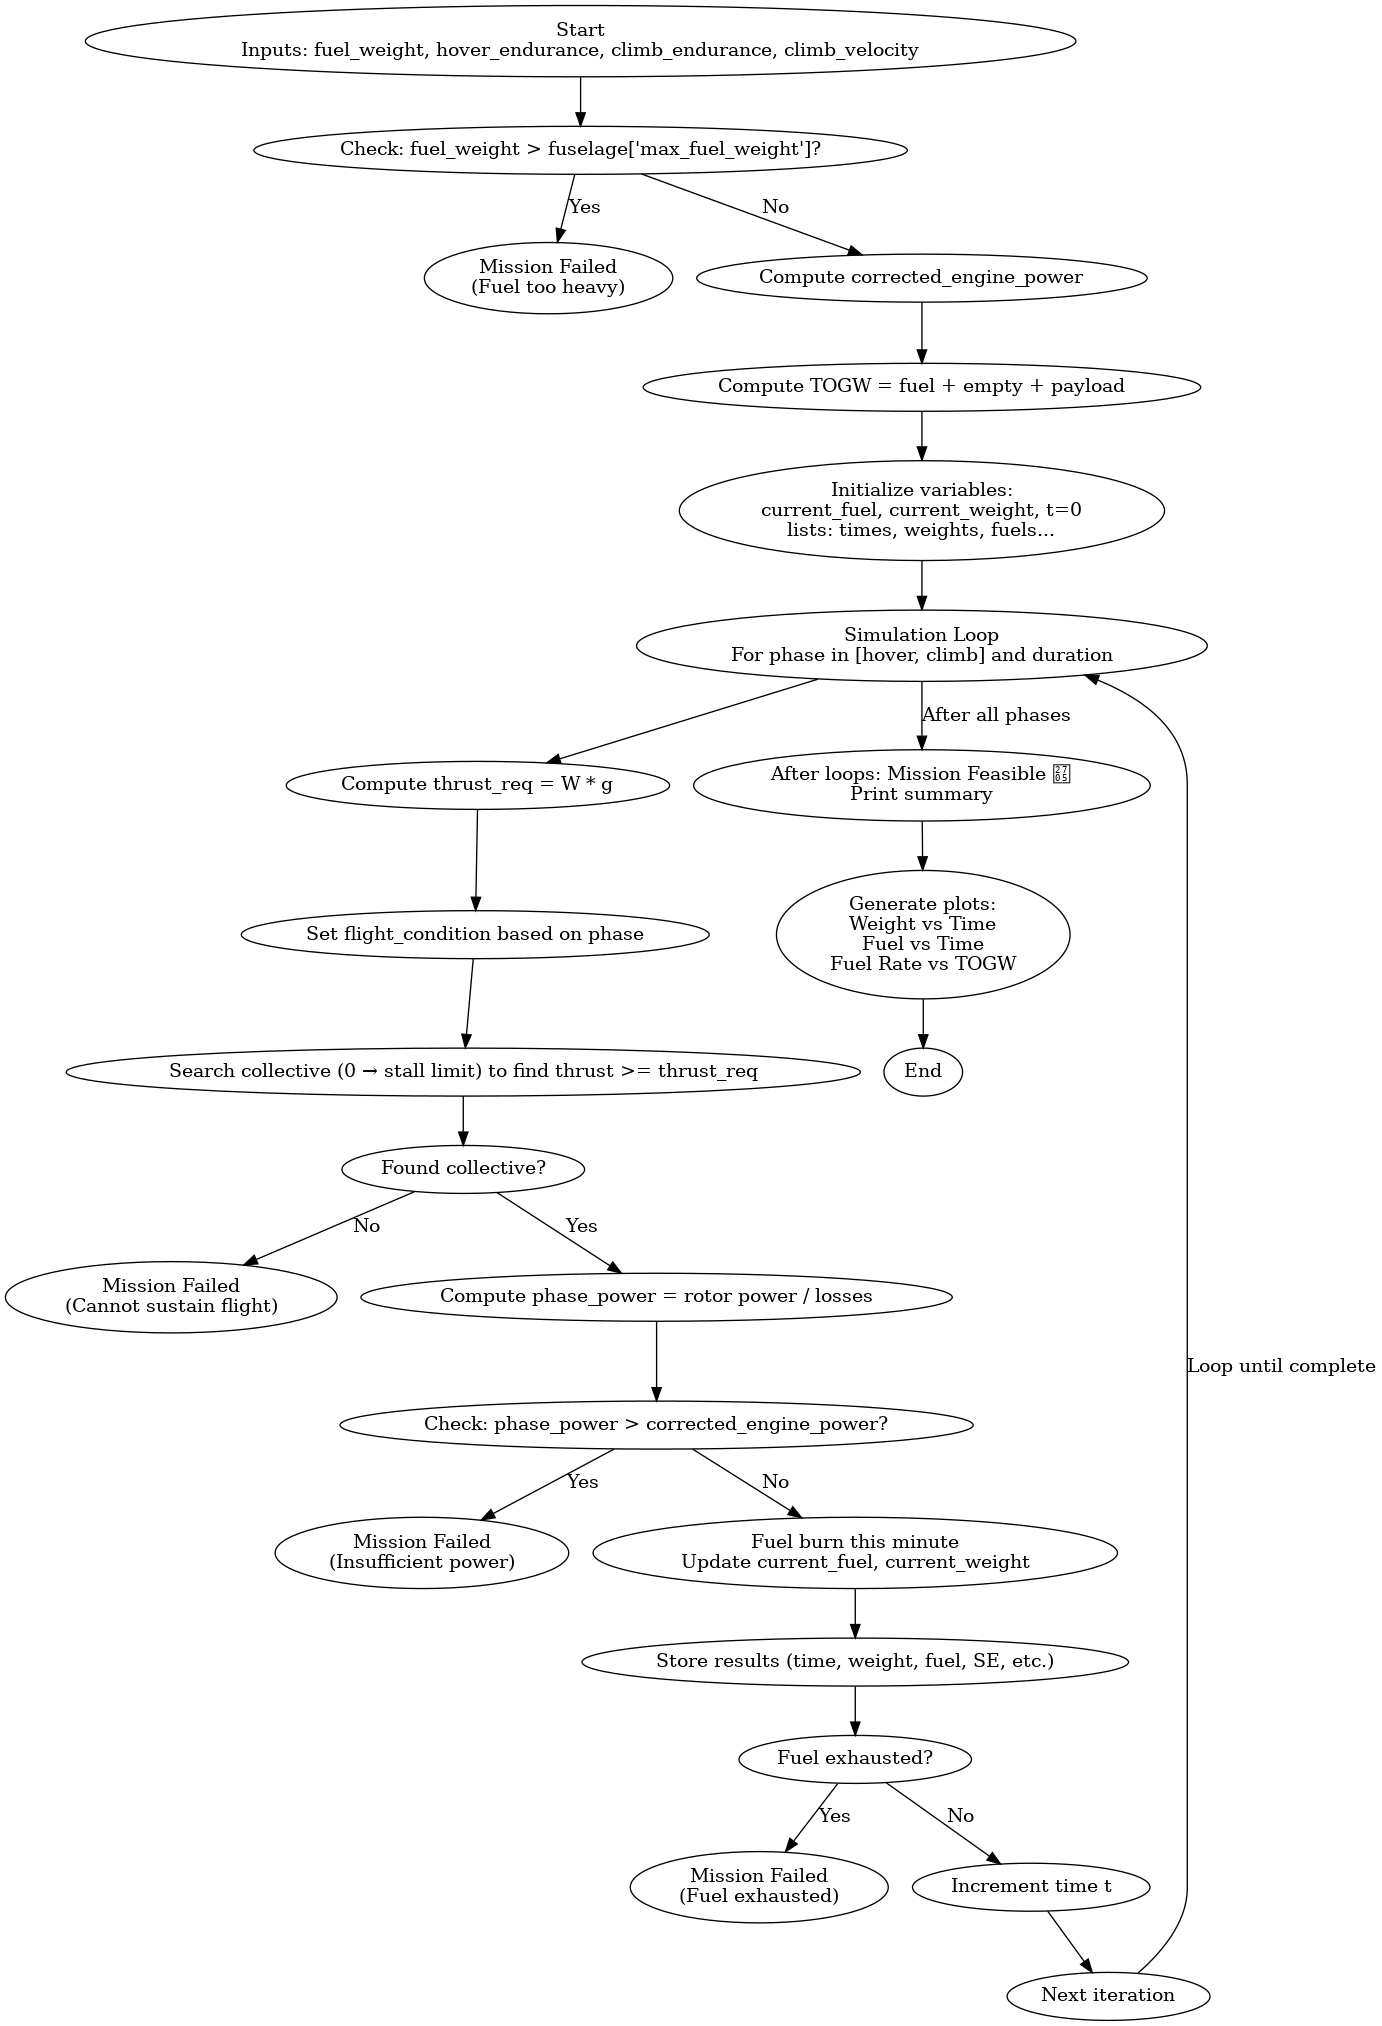

## Define Helicopter's parameters here for changing in Mission Planner

In [19]:
rotor= {
    "b": 4,
    "Rr": 1,
    "Rt": 8,
    "chord_root": 0.52,
    "chord_tip": 0.52,
    "theta_root": 10,
    "theta_tip": 0,
    "collective": 0
}

rotor_aero = {
    "Cl_alpha": 5.73,
    "Cl0": 0.2,
    "Cd0": 0.01,
    "alpha_stall": 13.0,
    "e": 0.8,
    "alpha0": -1,
    "Cm0": -0.02,
    "Cm_alpha": -0.5
}

tail_rotor = {
    "b": 2,
    "Rr": 0.1,
    "Rt": 0.75,
    "chord_root": 0.1,
    "chord_tip": 0.1,
    "theta_root": 4.0,
    "theta_tip": 0.0,
    "collective": 18,
    "power_fraction": 0.2
}

tail_rotor_aero= {
    "Cl_alpha": 5.73,
    "Cl0": 0.0,
    "Cd0": 0.08,
    "alpha_stall": 18.0,
    "e": 0.8,
    "alpha0": 0,
    "Cm0": -0.020,
    "Cm_alpha": 0
}

engine = {
    "max_power_avail": 3000000,
    "omega": 27,
    "bsfc": 0.3,
    "engines_loss": 0.15
}

fuselage = {
    "Cdx": 0,
    "Cdy": 0,
    "Cdz": 0,
    "X_area": 3.0,
    "Y_area": 4.0,
    "Z_area": 7.0,
    "max_fuel_weight": 1000,
    "Empty_Weight": 5000
}

horizontal_stabilizers = {
    "horiz_area": 4.18,
    "horiz_Cd": 0.05,
    "horiz_arm": 5.0
}

vertical_stabilizers = {
    "verti_area": 1.92,
    "verti_Cd": 0.05,
    "verti_arm": 5.0
}

flight_condition = {
    "altitude": 2000,
    "velocity": [0, 0,0],
    "wind": [0, 0, 0],
    "delta_ISA": 5
}

payload = {
    "weight": 700
}


TAKe offf gross weight 6300
b = 4
rho = 0.9927072111836429
altitude = 2000
R_tip = 8
R_root = 1
Omega = 27
sigma = 0.08276057040778557
a = 5.73
V_val = 0
AR = 13.461538461538462

Sample values at selected r:
 r (m)  theta (deg)  F (tip loss)  lambda  v_induced (m/s)  phi (deg)  chord (m)     Cl      Cd
 1.000       10.000           1.0 0.01696           3.6639      7.728       0.52 0.5272 0.01822
 1.778        8.889           1.0 0.02442           5.2742      6.270       0.52 0.5619 0.01933
 2.556        7.778           1.0 0.02909           6.2832      5.203       0.52 0.5575 0.01919
 3.333        6.667           1.0 0.03162           6.8293      4.339       0.52 0.5328 0.01839
 4.111        5.556           1.0 0.03227           6.9693      3.593       0.52 0.4963 0.01728
 4.889        4.444           1.0 0.03109           6.7163      2.913       0.52 0.4532 0.01607
 5.667        3.333           1.0 0.02799           6.0461      2.263       0.52 0.4070 0.01490
 6.444        2.222     

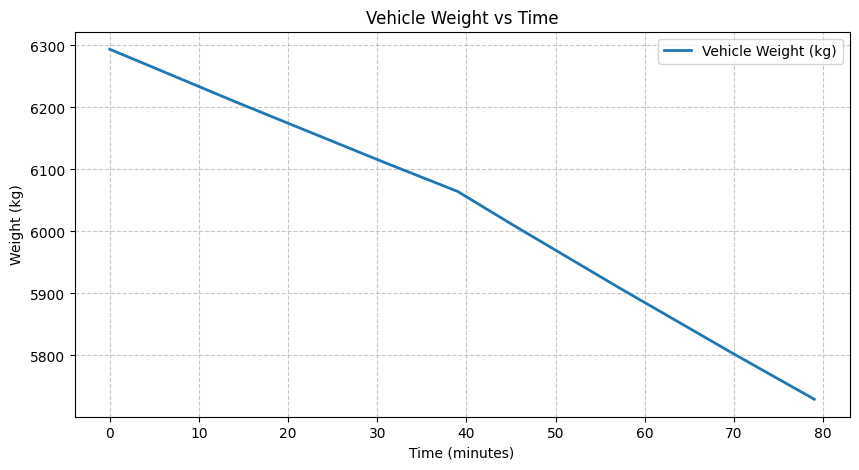

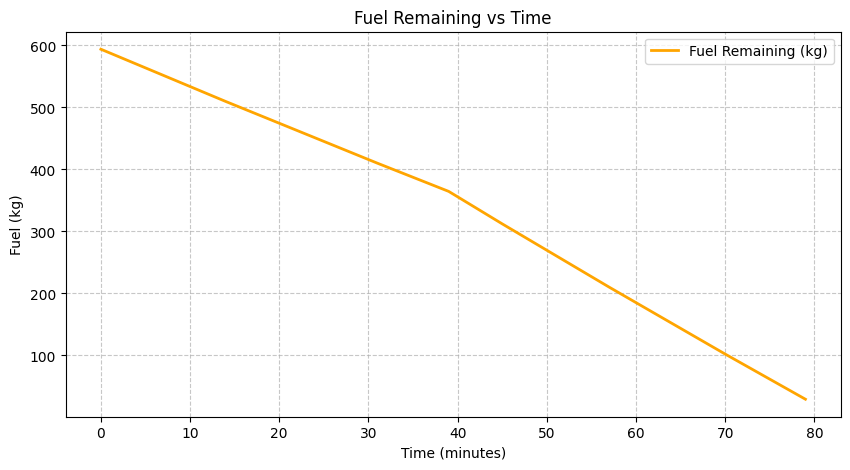

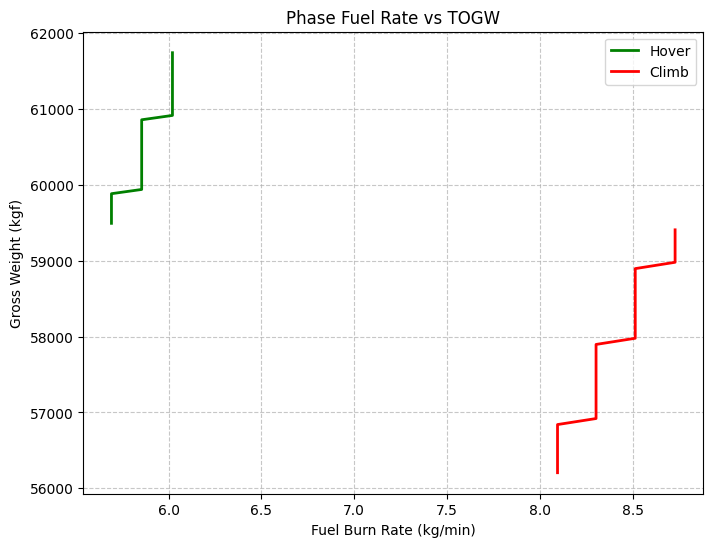

In [23]:
Mission_Planner(fuel_weight=600, hover_endurance=40, climb_endurance=40, climb_velocity=10)

In [21]:
#Sim_Start(rotor=rotor, rotor_aero=rotor_aero, engine=engine, flight_condition=flight_condition)